In [25]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [26]:
# Load the preprocessed dataset
train_data = pd.read_csv(r"Processed_datasets/train_preprocessed.csv")

# Check the distribution of classes
class_counts = train_data['incidentgrade'].value_counts()
print("Class distribution before trimming:")
print(class_counts)

# Calculate the number of rows to keep (2% of each class)
keep_fraction = 0.02  # 2% of each class
n_rows_to_keep_per_class = (class_counts * keep_fraction).astype(int)

# Create an empty DataFrame to store the sampled rows that will be kept
trimmed_data = pd.DataFrame()

# Loop through each class and sample the specified number of rows to keep
for grade, count in n_rows_to_keep_per_class.items():
    class_data = train_data[train_data['incidentgrade'] == grade]
    
    # Sample the specified number of rows to keep from the class
    sampled_class_data = class_data.sample(n=count, random_state=42)
    
    # Append the sampled data to the final DataFrame
    trimmed_data = pd.concat([trimmed_data, sampled_class_data], ignore_index=True)

# Check the new class distribution after trimming
trimmed_class_counts = trimmed_data['incidentgrade'].value_counts()
print("\nClass distribution after trimming (2% of each class):")
print(trimmed_class_counts)

# save the trimmed data to a new CSV file
trimmed_data.to_csv("Processed_datasets/train_trimmed_2%.csv", index=False)



Class distribution before trimming:
incidentgrade
0    4110747
2    3302643
1    2029564
Name: count, dtype: int64

Class distribution after trimming (2% of each class):
incidentgrade
0    82214
2    66052
1    40591
Name: count, dtype: int64


In [27]:
# Load the equal proportionaly trimmed dataset
df = pd.read_csv(r"Processed_datasets/train_trimmed_2%.csv")

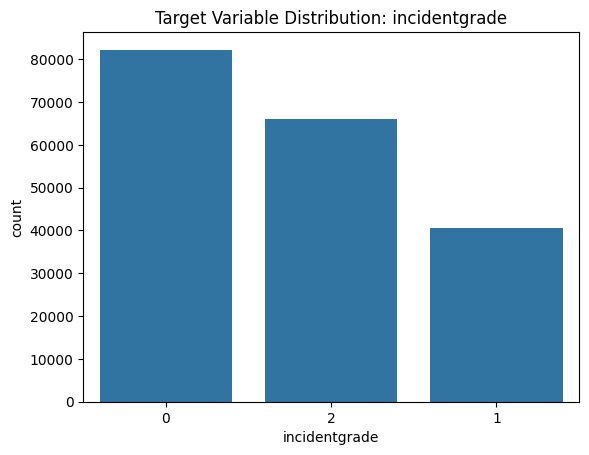

0: BenignPositive
1: FalsePositive
2: TruePositive


In [28]:
sns.countplot(data=df, x='incidentgrade', order=df['incidentgrade'].value_counts().index)
plt.title('Target Variable Distribution: incidentgrade')
plt.xlabel('incidentgrade')
plt.ylabel('count')
plt.show()
print("0: BenignPositive")
print("1: FalsePositive")
print("2: TruePositive")

In [29]:
df.head()

,incidentid,alertid,detectorid,alerttitle,category,incidentgrade,entitytype,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,year,month,day,hour,evidencerole_related
0,302855,249168,2,2,1,0,32,289573,117668,3586,5,66,242,1445,10630,2024,6,10,13,False
1,566,699603,2,2,1,0,31,289573,117668,3586,5,66,242,1445,10630,2024,6,14,17,True
2,877,476258,108,56028,7,0,11,146391,15974,3586,5,66,242,1445,10630,2024,6,16,20,False
3,495063,556657,5,829,16,0,15,289573,117668,3586,5,66,242,1445,10630,2024,6,4,23,True
4,5926,80023,13,11,10,0,20,289573,117668,3586,5,66,242,1445,10630,2024,6,5,14,False


#### 1. split the datasets into training and testing sets

In [30]:
# 'df' is our DataFrame and 'incidentgrade' is our target variable
X = df.drop(columns=['incidentgrade'])
y = df['incidentgrade']

# Step 1: Split the data into 80% training and 20% remaining (validation + test)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Split the remaining 20% into 50% validation and 50% test
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining)

# Check the sizes of the resulting splits
print(f'Training features (80% of total data) size: {X_train.shape[0]}')
print(f'Training target (80% of total data) size: {y_train.shape[0]}')
print(f'Validation features (10% of total data) size: {X_val.shape[0]}')
print(f'Validation target (10% of total data) size: {y_val.shape[0]}')
print(f'Test features (10% of total data) size: {X_test.shape[0]}')
print(f'Test target (10% of total data) size: {y_test.shape[0]}')

Training features (80% of total data) size: 151085
Training target (80% of total data) size: 151085
Validation features (10% of total data) size: 18886
Validation target (10% of total data) size: 18886
Test features (10% of total data) size: 18886
Test target (10% of total data) size: 18886


* Downsample BP to match the size of TP
* apply SMOTE to FP (minority class to match other classes)

#### 2. Separate the Classes

In [31]:
# Separate each class based on numerical labels
X_train_benignpositive = X_train[y_train == 0]  #benignpositive = 0
y_train_benignpositive = y_train[y_train == 0]

X_train_falsepositive = X_train[y_train == 1]  #falsepositive = 1
y_train_falsepositive = y_train[y_train == 1]

X_train_truepositive = X_train[y_train == 2]  #truepositive = 2
y_train_truepositive = y_train[y_train == 2]

#### 3. Downsample BP to the Size of TP

In [32]:
# Get the size of the middle class (falsepositive)
min_samples = len(y_train_truepositive)

# Downsample benignpositive to the size of truepositive (middle class)
X_train_benignpositive_downsampled, y_train_benignpositive_downsampled = resample(
    X_train_benignpositive,
    y_train_benignpositive,
    replace=False, 
    n_samples=min_samples,  # Match the size of falsepositive
    random_state=42  # For reproducibility
)


#### 4. Combine Downsampled BP with TP

In [33]:
# Combine downsampled benignpositive with falsepositive
X_train_combined = pd.concat([X_train_benignpositive_downsampled, X_train_falsepositive, X_train_truepositive])
y_train_combined = pd.concat([y_train_benignpositive_downsampled, y_train_falsepositive, y_train_truepositive])

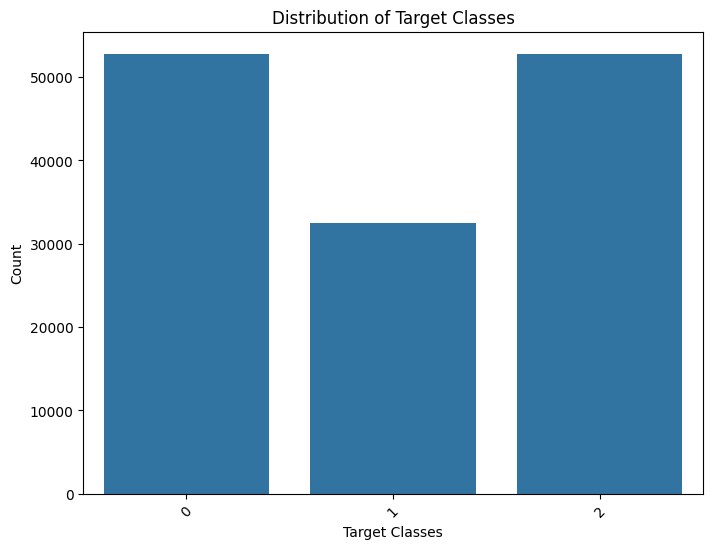

{'benignpositive': 0, 'falsepositive': 1, 'truepositive': 2}


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of classes in y_train_combined
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_combined)
plt.title('Distribution of Target Classes')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print("{'benignpositive': 0, 'falsepositive': 1, 'truepositive': 2}")


In [35]:
y_train_combined.value_counts()

incidentgrade
0    52841
2    52841
1    32473
Name: count, dtype: int64

#### 5. Apply smote to the minority Class (FP)

In [36]:
# Apply SMOTE to the combined training data
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train_combined)

# Check the shape of the resampled dataset
print(f"Original training dataset shape: {X_train_combined.shape}, {y_train_combined.shape}")
print(f"Resampled training dataset shape: {X_train_smote.shape}, {y_train_smote.shape}")

# class distribution before and after SMOTE
print("Class distribution before SMOTE:")
print(y_train_combined.value_counts())

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Original training dataset shape: (138155, 19), (138155,)
Resampled training dataset shape: (158523, 19), (158523,)
Class distribution before SMOTE:
incidentgrade
0    52841
2    52841
1    32473
Name: count, dtype: int64
Class distribution after SMOTE:
incidentgrade
0    52841
1    52841
2    52841
Name: count, dtype: int64


In [37]:
y_train_smote.value_counts()

incidentgrade
0    52841
1    52841
2    52841
Name: count, dtype: int64

In [38]:
# store model performance metrics
report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [],
    'Macro-F1 Score': [],
    'Precision': [],
    'Recall': []
}

In [39]:
# Function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_val_pred)
    macro_f1 = f1_score(y_val, y_val_pred, average='macro')
    precision = precision_score(y_val, y_val_pred, average='macro')
    recall = recall_score(y_val, y_val_pred, average='macro')
    
    return accuracy, macro_f1, precision, recall

##  Basic Models

#### Logistic Regression

In [40]:
# Logistic Regression with Scaling
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
acc, f1, prec, rec = evaluate_model(log_reg, X_train, y_train, X_val, y_val)
report['Accuracy'].append(acc)
report['Macro-F1 Score'].append(f1)
report['Precision'].append(prec)
report['Recall'].append(rec)

#### Decision Tree Classifier

In [41]:
# Decision Tree
tree = DecisionTreeClassifier()
acc, f1, prec, rec = evaluate_model(tree, X_train, y_train, X_val, y_val)
report['Accuracy'].append(acc)
report['Macro-F1 Score'].append(f1)
report['Precision'].append(prec)
report['Recall'].append(rec)

##  Advanced Models

#### Random Forest Classifier

In [42]:
# Random Forest
rf = RandomForestClassifier()
acc, f1, prec, rec = evaluate_model(rf, X_train, y_train, X_val, y_val)
report['Accuracy'].append(acc)
report['Macro-F1 Score'].append(f1)
report['Precision'].append(prec)
report['Recall'].append(rec)

#### XGBoost Classifier

In [43]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
acc, f1, prec, rec = evaluate_model(xgb, X_train, y_train, X_val, y_val)
report['Accuracy'].append(acc)
report['Macro-F1 Score'].append(f1)
report['Precision'].append(prec)
report['Recall'].append(rec)

C:\Users\Phoenix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### LightGBM Classifier

In [44]:
# LightGBM
lgbm = LGBMClassifier()
acc, f1, prec, rec = evaluate_model(lgbm, X_train, y_train, X_val, y_val)
report['Accuracy'].append(acc)
report['Macro-F1 Score'].append(f1)
report['Precision'].append(prec)
report['Recall'].append(rec)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 151085, number of used features: 18
[LightGBM] [Info] Start training from score -0.831664
[LightGBM] [Info] Start training from score -1.537434
[LightGBM] [Info] Start training from score -1.050555


### REPORT

In [45]:
report_df = pd.DataFrame(report)
print(report_df)

                 Model  Accuracy  Macro-F1 Score  Precision    Recall
0  Logistic Regression  0.585248        0.470493   0.586093  0.499264
1        Decision Tree  0.863179        0.858413   0.857942  0.858911
2        Random Forest  0.869957        0.864994   0.880646  0.854633
3              XGBoost  0.849518        0.843698   0.872346  0.828224
4             LightGBM  0.834216        0.826285   0.863494  0.808228


#### Cross Validation

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assuming the Random Forest model has already been trained on the SMOTE-augmented data
rf_model = RandomForestClassifier(random_state=42)

# Perform cross-validation on the Random Forest model
cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=5)

# Print cross-validation results
print(f"Random Forest Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Random Forest Cross-Validation Scores: [0.85336698 0.85604794 0.85207381 0.89237951 0.89307343]
Mean CV Score: 0.86938833277363


#### Hyperparameter Tuning (GridSearchCV)

In [47]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Assuming X_train_smote and y_train_smote are your features and target variable after SMOTE
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Define a simpler parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Reduced range for faster training
    'max_depth': randint(10, 30),      # Moderate depth for performance balance
    'min_samples_split': randint(2, 10),  # Reduced range for faster convergence
    'min_samples_leaf': randint(1, 5),  # Reduced range for faster convergence
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Fewer iterations for faster results
    scoring='accuracy',  # Replace with your preferred scoring metric
    n_jobs=-1,  # Use all available cores
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_smote, y_train_smote)

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

# Best model
best_rf_model = random_search.best_estimator_

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_rf_model, X_train_smote, y_train_smote, cv=5)

# Print cross-validation results
print(f"Random Forest Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 139}
Random Forest Cross-Validation Scores: [0.85172686 0.85402933 0.85134837 0.89228489 0.89266339]
Mean CV Score: 0.8684105658304464


#### Retrain the best model on tuned hyper parameters

In [54]:
# Importing necessary library
from sklearn.ensemble import RandomForestClassifier

# Best hyperparameters obtained from the hyperparameter tuning (GridSearchCV)
best_rf = RandomForestClassifier(
    bootstrap=False,      
    max_depth=27,         
    min_samples_leaf=2,   
    min_samples_split=2,  
    n_estimators=139,    
    random_state=42       
)

# Retrain the model on the SMOTE-resampled training set
best_rf.fit(X_train_smote, y_train_smote)

# print out the model parameters
print("Trained model with the following best parameters:")
print(best_rf.get_params())


Trained model with the following best parameters:
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 139, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#### performance of tuned model on smote dataset

In [55]:
# Predict on the SMOTE-resampled training set
y_pred_train = best_rf.predict(X_train_smote)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train_smote, y_pred_train)
train_macro_f1 = f1_score(y_train_smote, y_pred_train, average='macro')
train_precision = precision_score(y_train_smote, y_pred_train, average='macro')
train_recall = recall_score(y_train_smote, y_pred_train, average='macro')

# Print evaluation results on training set
print("Training Set Evaluation:")
print(f"Accuracy: {train_accuracy}")
print(f"Macro F1 Score: {train_macro_f1}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")

Training Set Evaluation:
Accuracy: 0.9750698636790875
Macro F1 Score: 0.9751495539126381
Precision: 0.9758517023230461
Recall: 0.9750698636790877


#### performance of tuned model on original dataset

In [56]:
# Predict on the original test set
y_pred_test = best_rf.predict(X_test)

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro')
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')

# Print evaluation results on test set
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Macro F1 Score: {test_macro_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")


Test Set Evaluation:
Accuracy: 0.8610081541882876
Macro F1 Score: 0.8564349244032919
Precision: 0.8634583163209454
Recall: 0.8519513880846032


In [ ]:
# Retrain the model with the best parameters
best_rf = random_search.best_estimator_

# Evaluate on the training set (you can also use a separate test set)
y_pred_best_rf = best_rf.predict(X_train_smote)

# Model evaluation metrics
print("Accuracy:", accuracy_score(y_train_smote, y_pred_best_rf))
print("Macro-F1 Score:", f1_score(y_train_smote, y_pred_best_rf, average='macro'))
print("Precision:", precision_score(y_train_smote, y_pred_best_rf, average='macro'))
print("Recall:", recall_score(y_train_smote, y_pred_best_rf, average='macro'))

Accuracy: 0.9750698636790875
Macro-F1 Score: 0.9751495539126381
Precision: 0.9758517023230461
Recall: 0.9750698636790877


#### classification report

In [58]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
# Classification report for detailed metrics
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\nConfusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_pred_test))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      8222
           1       0.84      0.82      0.83      4059
           2       0.91      0.83      0.87      6605

    accuracy                           0.86     18886
   macro avg       0.86      0.85      0.86     18886
weighted avg       0.86      0.86      0.86     18886


Confusion Matrix on Test Set:
[[7466  386  370]
 [ 575 3330  154]
 [ 909  231 5465]]


#### save the best tuned model

In [59]:
# Performance threshold: Save the model if the test accuracy is above a threshold
performance_threshold = 0.85  # Example threshold

if test_accuracy >= performance_threshold:
    # Save the model if it meets the performance criteria
    joblib.dump(best_rf, 'best_rf_model.pkl')
    print("\nModel saved as 'best_rf_model.pkl' since it meets the performance criteria.")
else:
    print("\nModel does not meet the performance criteria, so not saved.")


Model saved as 'best_rf_model.pkl' since it meets the performance criteria.


## Evaluate Model on Given (Test Dataset)

In [62]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Load the preprocessed test dataset
test_data_path = r"Processed_datasets/train_preprocessed.csv"
test_data = pd.read_csv(test_data_path)

# Extract features and target variable from test dataset
X_test = test_data.drop('incidentgrade', axis=1)  # Replace 'incidentgrade' with your target column name
y_test = test_data['incidentgrade']

# Load the final model (the one with hyperparameters tuned)
final_model = joblib.load('best_rf_model.pkl') 

# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro')
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')

# Print evaluation results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro-F1 Score: {test_macro_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Test Accuracy: 0.8653
Test Macro-F1 Score: 0.8607
Test Precision: 0.8671
Test Recall: 0.8565
Confusion Matrix:
[[3736735  198401  175611]
 [ 280234 1673070   76260]
 [ 433004  108279 2761360]]
